In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd

import importlib

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import policies
import bbDebiasing as bbDebias
import maxEnsembleDebias as maxDebias

import matplotlib.pyplot as plt

import time

In [2]:
# reading in the data
data = pd.read_csv('../options500', index_col=0)

# check for nans
data.isna().sum()

date                           0
strikes_spread_OSPN            0
calls_contracts_traded_OSPN    0
puts_contracts_traded_OSPN     0
calls_open_interest_OSPN       0
                              ..
hv_90_PTCT                     0
hv_120_PTCT                    0
hv_180_PTCT                    0
hv_200_PTCT                    0
VIX_PTCT                       0
Length: 1036, dtype: int64

In [3]:
# handle or drop date column
data = data.drop(columns='date')

In [4]:
covariates = list(data.columns)
targets = []

# only including some subset of targets in data
# target_names = ['DITM_IV', 'ITM_IV', 'sITM_IV', 'ATM_IV', 'sOTM_IV', 'OTM_IV', 'DOTM_IV']
target_names = ['DITM_IV']
for name in target_names:
    for f in covariates:
        if name in f:
            targets.append(f)
            covariates.remove(f)

In [5]:
X = data[covariates].values
Y = data[targets].values 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Training two gradient boosting regressors, one on for each of the first two (of 315 total) targets.

In [6]:
gb1 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb1.fit(X_train, Y_train[:,0])

gb2 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb2.fit(X_train, Y_train[:,1])

gb3 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb3.fit(X_train, Y_train[:,2])

gb4 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb4.fit(X_train, Y_train[:,3])

gb5 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb5.fit(X_train, Y_train[:,4])

gb6 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb6.fit(X_train, Y_train[:,5])

gb7 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb7.fit(X_train, Y_train[:,6])

gb8 = GradientBoostingRegressor(learning_rate=0.1, max_depth=6, random_state=42)
gb8.fit(X_train, Y_train[:,7])


GradientBoostingRegressor(max_depth=6, random_state=42)

Verifying that the error is at least sort of on correct scale for the data.

In [7]:
print(f"Min OT Value: {Y_train.min()}")
print(f"Max OT Value: {Y_train.max()}")
preds1 = gb1.predict(X_test)
preds2 = gb2.predict(X_test)
print(f"MSE of predictor on 1st target {mse(Y_test[:,0], preds1)}")
print(f"MSE of predictor on 2nd target {mse(Y_test[:,1], preds2)}")

Min OT Value: 8.09
Max OT Value: 146.92
MSE of predictor on 1st target 46.13378297654146
MSE of predictor on 2nd target 11.891566658329332


Building two composite predictors, which each use gradient boosting for one coordinate of prediction vector and predict label mean for other coordinate.  

In [8]:
def h1(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col1 = gb1.predict(xs)
    arr[:,0] = col1
    return arr

def h2(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col2 = gb2.predict(xs)
    arr[:,1] = col2
    return arr

def h3(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col = gb3.predict(xs)
    arr[:,2] = col
    return arr

def h4(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col = gb4.predict(xs)
    arr[:,3] = col
    return arr

def h5(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col = gb5.predict(xs)
    arr[:,4] = col
    return arr

def h6(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col = gb6.predict(xs)
    arr[:,5] = col
    return arr

def h7(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col = gb7.predict(xs)
    arr[:,6] = col
    return arr

def h8(xs):
    arr = np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])
    col = gb8.predict(xs)
    arr[:,7] = col
    return arr

In [9]:
policy1 = policies.LinearMin(len(Y_train[0]), h1, .1, Y_train)
policy2 = policies.LinearMin(len(Y_train[0]), h2, .1, Y_train)
policy3 = policies.LinearMin(len(Y_train[0]), h3, .1, Y_train)
policy4 = policies.LinearMin(len(Y_train[0]), h4, .1, Y_train)
policy5 = policies.LinearMin(len(Y_train[0]), h5, .1, Y_train)
policy6 = policies.LinearMin(len(Y_train[0]), h6, .1, Y_train)
policy7 = policies.LinearMin(len(Y_train[0]), h7, .1, Y_train)
policy8 = policies.LinearMin(len(Y_train[0]), h8, .1, Y_train)

# Bias Bounties Method

In [11]:
def init_model(xs):
    # col1 = np.full(len(xs), Y_train[:,0].mean())
    # col2 = np.full(len(xs), Y_train[:,1].mean())
    # return np.column_stack((col1, col2))
    return np.full([len(xs), len(Y_train[0])], [Y_train[:,i].mean() for i in range(len(Y_train[0]))])

init_policy = policies.LinearMin(len(Y_train[0]), init_model, .1, Y_train)

max_depth = 2000
tolerance = 0.01
bbModel = bbDebias.bbDebias(init_model, init_policy, X_train, Y_train, max_depth, tolerance)
bbModel.debias([h1,h2,h3,h4,h5,h6,h7,h8], [policy1, policy2, policy3, policy4, policy5, policy6, policy7, policy8])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-09
Maximum depth reached.


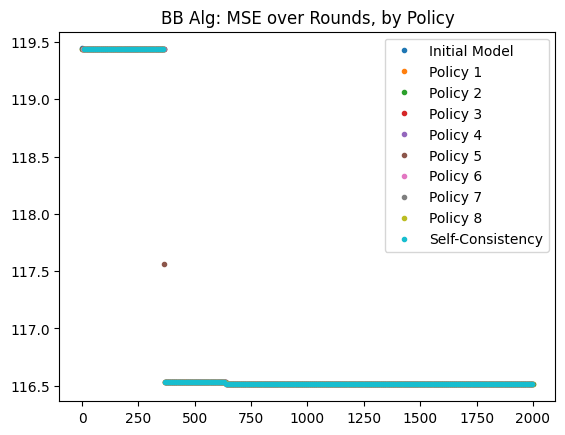

In [12]:
mses = np.array([mse(Y_train, pred, multioutput='raw_values') for pred in bbModel.predictions_by_round])

coord = 0
plt.plot(0,mses[0][coord],'.', label="Initial Model")
for i in range(1, bbModel.n_models+1):
    indices = list(range(len(bbModel.predictions_by_round)))[i::(bbModel.n_models + 1)]
    plt.plot(indices, mses[i::(bbModel.n_models + 1)][:, coord], '.', label=f"Policy {i}")
indices = list(range(len(bbModel.predictions_by_round)))[(bbModel.n_models+1)::(bbModel.n_models + 1)]
plt.plot(indices, mses[(bbModel.n_models+1)::(bbModel.n_models + 1)][:, coord], '.', label="Self-Consistency")
plt.legend()
plt.title("BB Alg: MSE over Rounds, by Policy");
plt.savefig("options, one target per option, eight models, LinearMin policy, init models are decision trees on one target and label mean on rest")
            

Comparison of MSE of our final model vs the MSEs of the original models in the first coordinate:

In [176]:
print(f"(Training) MSE of our model in 1st coordinate: {mses[-1][0]}")
print(f"(Training) MSE of model 1 in 1st coordinate:  {mse(Y_train, h1(X_train), multioutput='raw_values')[0]}")
print(f"(Training) MSE of model 2 in 1st coordinate: {mse(Y_train, h2(X_train), multioutput='raw_values')[0]}")

(Training) MSE of our model in 1st coordinate: 54.662486687016916
(Training) MSE of model 1 in 1st coordinate:  0.4060074991976695
(Training) MSE of model 2 in 1st coordinate: 119.4435328078223


I.e., at least with the naive simplex policy, we don't match performance of the better of the two initial predictors in terms of squared error. 

Comparison of MSE overall:

In [177]:
print(f"(Training) MSE of our model: {mses[-1].mean()}")
print(f"(Training) MSE of model 1:  {mse(Y_train, h1(X_train))}")
print(f"(Training) MSE of model 2: {mse(Y_train, h2(X_train))}")

(Training) MSE of our model: 67.25818159073066
(Training) MSE of model 1:  104.2000105003891
(Training) MSE of model 2: 105.17683686039058


So, we do better overall than the original models. 

In [ ]:
# predicted objective of each point per round
pred_rev = [np.einsum('ij,ij->i', bbModel.predictions_by_round[i], init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))] #fancy vectorized row-wise dot product 
# realized objective
true_rev = [np.einsum('ij,ij->i', Y_train, init_policy.run_given_preds(bbModel.predictions_by_round[i])) for i in range(len(bbModel.predictions_by_round))]


plt.plot(range(len(bbModel.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean obj of policy")
plt.plot(range(len(bbModel.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean obj of policy")
plt.legend()
plt.title("BB Alg: Predicted and Realized Objective over Rounds")
plt.savefig("options, one target per option, eight models, LinearMin policy, init models are decision trees on one target and label mean on rest 2")

# Max Ensemble Method

In [183]:
max_depth =1000
tolerance = 0.1
maxModel = maxDebias.EnsembledModel([h1,h2,h3,h4,h5,h6,h7,h8], [policy1, policy2, policy3, policy4, policy5, policy6, policy7, policy8], X_train, Y_train, max_depth, tolerance)
maxModel.debias()

Maximum depth reached.


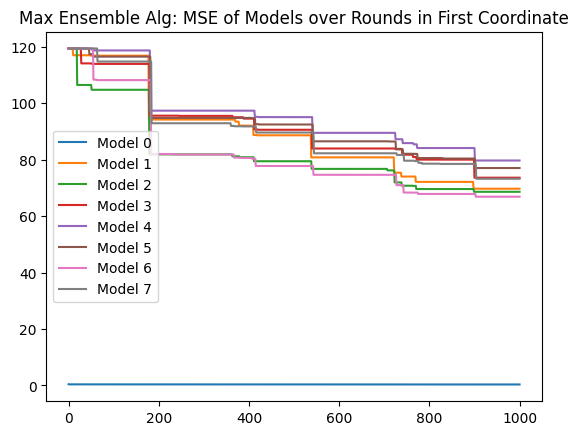

In [184]:
preds = np.array(maxModel.predictions_by_round)

preds_by_model = [preds[:,i] for i in range(maxModel.n_models)]
mses_by_model = np.zeros((len(preds_by_model), len(preds), maxModel.pred_dim))
for i in range(maxModel.n_models):
    for j in range(len(preds_by_model[i])):
        mses_by_model[i][j] = mse(Y_train, preds_by_model[i][j], multioutput='raw_values')

coord = 0
for i in range(maxModel.n_models):
    plt.plot(np.arange(len(maxModel.predictions_by_round)), mses_by_model[i][:,coord], label=f"Model {i}")
plt.legend()
plt.title("MaxModel: MSE of Models over Rounds in First Coordinate");
plt.savefig("options, one target per option, eight models, LinearMin policy, init models are decision trees on one target and label mean on rest 5")


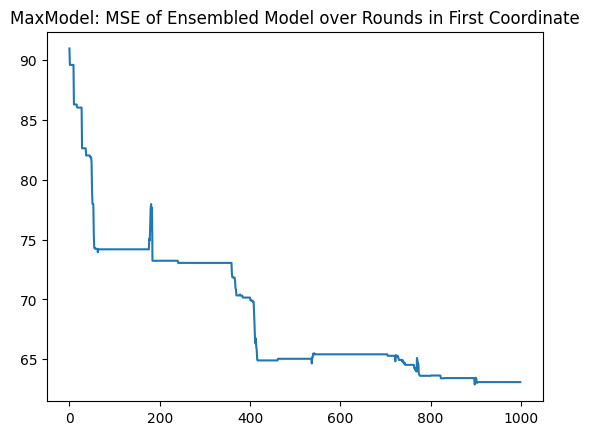

In [197]:
ensemble_mse = np.array([mse(Y_train, maxModel.meta_model_pred_by_round[i]) for i in range(len(maxModel.meta_model_pred_by_round))])
coord = 0

plt.plot(np.arange(len(ensemble_mse)), ensemble_mse)
plt.title("MaxModel: MSE of Ensembled Model over Rounds in First Coordinate");
plt.savefig("options, one target per option, eight models, LinearMin policy, init models are decision trees on one target and label mean on rest 6")


Comparing final MSEs of meta algorithm, BB method, and original models

In [96]:
print(f"(Training) MSE of BB Model in 1st coordinate: {mse(Y_train, bbModel.predictions_by_round[-1], multioutput='raw_values')[0]}")
print(f"(Training) MSE of Max Ensemble Model in 1st coordinate: {mse(Y_train, maxModel.meta_model_pred_by_round[-1], multioutput='raw_values')[0]}")
print(f"(Training) MSE of Model 1 in 1st coordinate:  {mse(Y_train, h1(X_train), multioutput='raw_values')[0]}")
print(f"(Training) MSE of Model 2 in 1st coordinate: {mse(Y_train, h2(X_train), multioutput='raw_values')[0]}")

(Training) MSE of BB Model in 1st coordinate: 69.92925380058637
(Training) MSE of Max Ensemble Model in 1st coordinate: 6.285508018917751
(Training) MSE of Model 1 in 1st coordinate:  3.7359070438953985
(Training) MSE of Model 2 in 1st coordinate: 119.4435328078223


And overall MSE

In [97]:
print(f"(Training) MSE of BB Model: {mse(Y_train, bbModel.predictions_by_round[-1])}")
print(f"(Training) MSE of Max Ensemble Model: {ensemble_mse[-1]}")
print(f"(Training) MSE of Model 1:  {mse(Y_train, h1(X_train))}")
print(f"(Training) MSE of Model 2: {mse(Y_train, h2(X_train))}")

(Training) MSE of BB Model: 84.71430707348631
(Training) MSE of Max Ensemble Model: 81.81313197315094
(Training) MSE of Model 1:  96.71069636749795
(Training) MSE of Model 2: 96.84005617455229


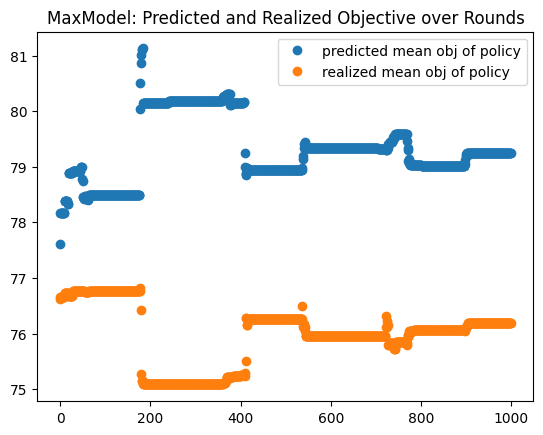

In [191]:
# predicted objective of each point per round
# pred_rev = [np.einsum('ij,ij->i', maxModel.meta_model_pred_by_round[i], maxModel.meta_policy_choice_by_round[i]) for i in range(len(maxModel.predictions_by_round ))] #fancy vectorized row-wise dot product 
pred_rev = [np.einsum('ij,ij->i', maxModel.meta_model_pred_by_round[i], maxModel.meta_policy_choice_by_round[i]) for i in range( 1000 )] #fancy vectorized row-wise dot product 
# realized objective
# true_rev = [np.einsum('ij,ij->i', Y_train, maxModel.meta_policy_choice_by_round[i]) for i in range(len(maxModel.predictions_by_round ))]
true_rev = [np.einsum('ij,ij->i', Y_train, maxModel.meta_policy_choice_by_round[i]) for i in range( 1000 )]


# plt.plot(range(len(maxModel.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean obj of policy")
plt.plot(range( 1000 ), np.mean(pred_rev, axis=1), 'o', label="predicted mean obj of policy")
# plt.plot(range(len(maxModel.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean obj of policy")
plt.plot(range( 1000 ), np.mean(true_rev, axis=1), 'o', label="realized mean obj of policy")
plt.legend()
plt.title("MaxModel: Predicted and Realized Objective over Rounds")
plt.savefig("options, one target per option, eight models, LinearMin policy, init models are decision trees on one target and label mean on rest 7")

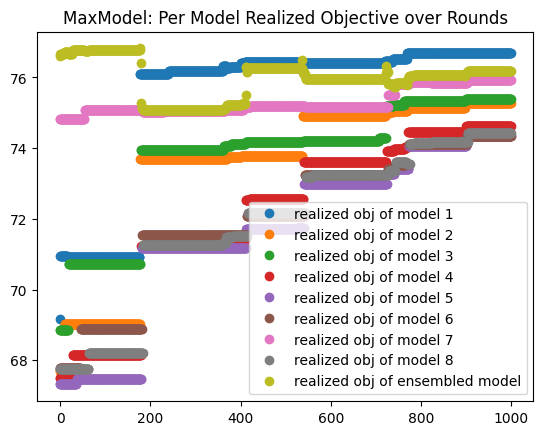

In [195]:
# predicted objective of each point per round
rev_1 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][0], policy1.run_given_preds(maxModel.predictions_by_round[i][0])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_2 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][1], policy2.run_given_preds(maxModel.predictions_by_round[i][1])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_3 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][2], policy3.run_given_preds(maxModel.predictions_by_round[i][2])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_4 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][3], policy4.run_given_preds(maxModel.predictions_by_round[i][3])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_5 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][4], policy5.run_given_preds(maxModel.predictions_by_round[i][4])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_6 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][5], policy6.run_given_preds(maxModel.predictions_by_round[i][5])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_7 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][6], policy7.run_given_preds(maxModel.predictions_by_round[i][6])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_8 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][7], policy8.run_given_preds(maxModel.predictions_by_round[i][7])) for i in range( 1000 )] #fancy vectorized row-wise dot product 
rev_meta = [np.einsum('ij,ij->i', Y_train, maxModel.meta_policy_choice_by_round[i]) for i in range( 1000 )]

# self.predictions_by_round = [np.copy(self.curr_preds)] # shape self.curr_depth * k + 1; entry (i,j) is predictions on training data of model j after i rounds of debiasing

# plt.plot(range(len(maxModel.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean obj of policy")
plt.plot(range( 1000 ), np.mean(rev_1, axis=1), 'o', label="realized obj of model 1")
plt.plot(range( 1000 ), np.mean(rev_2, axis=1), 'o', label="realized obj of model 2")
plt.plot(range( 1000 ), np.mean(rev_3, axis=1), 'o', label="realized obj of model 3")
plt.plot(range( 1000 ), np.mean(rev_4, axis=1), 'o', label="realized obj of model 4")
plt.plot(range( 1000 ), np.mean(rev_5, axis=1), 'o', label="realized obj of model 5")
plt.plot(range( 1000 ), np.mean(rev_6, axis=1), 'o', label="realized obj of model 6")
plt.plot(range( 1000 ), np.mean(rev_7, axis=1), 'o', label="realized obj of model 7")
plt.plot(range( 1000 ), np.mean(rev_8, axis=1), 'o', label="realized obj of model 8")
# plt.plot(range(len(maxModel.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean obj of policy")
plt.plot(range( 1000 ), np.mean(rev_meta, axis=1), 'o', label="realized obj of ensembled model")
plt.legend()
plt.title("MaxModel: Per Model Realized Objective over Rounds")
plt.savefig("options, one target per option, eight models, LinearMin policy, init models are decision trees on one target and label mean on rest 7")

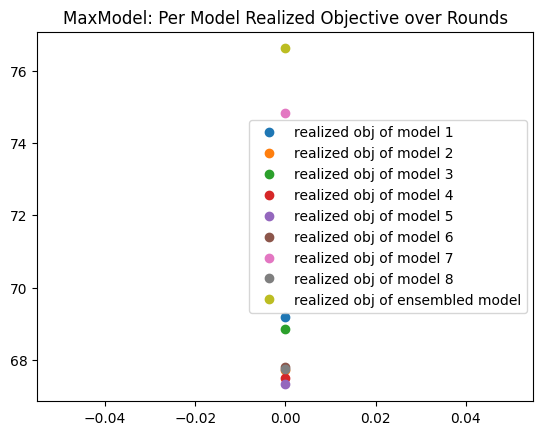

In [196]:
# predicted objective of each point per round
rev_1 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][0], policy1.run_given_preds(maxModel.predictions_by_round[i][0])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_2 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][1], policy2.run_given_preds(maxModel.predictions_by_round[i][1])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_3 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][2], policy3.run_given_preds(maxModel.predictions_by_round[i][2])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_4 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][3], policy4.run_given_preds(maxModel.predictions_by_round[i][3])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_5 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][4], policy5.run_given_preds(maxModel.predictions_by_round[i][4])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_6 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][5], policy6.run_given_preds(maxModel.predictions_by_round[i][5])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_7 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][6], policy7.run_given_preds(maxModel.predictions_by_round[i][6])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_8 = [np.einsum('ij,ij->i', maxModel.predictions_by_round[i][7], policy8.run_given_preds(maxModel.predictions_by_round[i][7])) for i in range( 1 )] #fancy vectorized row-wise dot product 
rev_meta = [np.einsum('ij,ij->i', Y_train, maxModel.meta_policy_choice_by_round[i]) for i in range( 1 )]

In [ ]:
# plt.plot(range(len(maxModel.predictions_by_round)), np.mean(pred_rev, axis=1), 'o', label="predicted mean obj of policy")
plt.plot(range( 1 ), np.mean(rev_1, axis=1), 'o', label="realized obj of model 1")
plt.plot(range( 1 ), np.mean(rev_2, axis=1), 'o', label="realized obj of model 2")
plt.plot(range( 1 ), np.mean(rev_3, axis=1), 'o', label="realized obj of model 3")
plt.plot(range( 1 ), np.mean(rev_4, axis=1), 'o', label="realized obj of model 4")
plt.plot(range( 1 ), np.mean(rev_5, axis=1), 'o', label="realized obj of model 5")
plt.plot(range( 1 ), np.mean(rev_6, axis=1), 'o', label="realized obj of model 6")
plt.plot(range( 1 ), np.mean(rev_7, axis=1), 'o', label="realized obj of model 7")
plt.plot(range( 1 ), np.mean(rev_8, axis=1), 'o', label="realized obj of model 8")
# plt.plot(range(len(maxModel.predictions_by_round)), np.mean(true_rev, axis=1), 'o', label="realized mean obj of policy")
plt.plot(range( 1 ), np.mean(rev_meta, axis=1), 'o', label="realized obj of ensembled model")
plt.legend()
plt.title("MaxModel: Per Model Realized Objective over Rounds")
plt.savefig("options, one target per option, eight models, LinearMin policy, init models are decision trees on one target and label mean on rest 8")